In [1]:
%matplotlib inline

import pandas as pd # Библиотека для работы с датафреймом
from tensorflow.keras import utils # Будем использовать эту библиотеку для 
import numpy as np # Библиотека для работы с массивами
import matplotlib.pyplot as plt # Будем визулизировать данные этой библиотекой
import re # Регулряные выражения для эффективной работы со строками
from pylab import rcParams
from sklearn.model_selection import train_test_split # Импортируем модуль train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential # НС прямого распространения
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization, Input # Основные слои
from tensorflow.keras import utils # Утилиты для to_categorical
from tensorflow.keras.optimizers import Adam, RMSprop  # Алгоритмы оптимизации, для настройки скорости обучения
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import LambdaCallback # библиотеки для создания callback
from IPython.display import clear_output
import time
import datetime
import keras.backend as K
import sys, traceback, gc

In [2]:
basa = pd.read_csv('H:\DATA_SET\moscow_parsed_simple.csv', index_col=False, dtype='unicode')

In [3]:
basa.head()

,Unnamed: 0,Комнат,Метро / ЖД станции,От станции,Дом,Балкон,Санузел,Площадь,"Цена, руб.",ГРМ,Бонус агенту,Дата,Кол-во дней в экспозиции
0,0,1,Шелепиха м.,12п,35/37 М,NaN,2,64.1/23/20,19500000.0,NaN,NaN,25.07.2019,1.0
1,1,1,Пятницкое шоссе м.,30т,11/14 П,Л,Р,38.4/17/9,4800000.0,NaN,NaN,25.07.2019,2.0
2,2,1,Планерная м.,5т,11/22 П,Б,С,38.2/19.9/9.9,7990000.0,NaN,NaN,25.07.2019,4.0
3,3,1,Шаболовская м.,12п,8/12 ?,Б,Р,38/15/7,11200000.0,NaN,NaN,25.07.2019,7.0
4,4,1,Бабушкинская м.,15п,4/14 П,NaN,С,34/17/8,6250000.0,NaN,NaN,25.07.2019,11.0


In [4]:
basa.drop(basa.columns[0], axis=1,inplace=True)      # Уберем столбцы, которые не влияют или незначительно влияют на конечуню цену квартиры
basa.drop(basa.columns[10], axis=1,inplace=True)
basa =basa.rename(columns={'Метро / ЖД станции': 'Метро'})
basa.drop(columns=['Дом', 'ГРМ', 'Бонус агенту', 'Кол-во дней в экспозиции'],inplace=True )

In [5]:
basa['Метро'] = basa['Метро'].replace(to_replace=' м.', value="",regex=True)
basa['Метро'] = basa['Метро'].replace(to_replace='МЦК', value="",regex=True)   # Преобразуем столбец "Метро", оставив в нем только названия станций
basa['Метро'] = basa['Метро'].replace(to_replace='\(*\)*', value="",regex=True)

In [6]:
metro = pd.read_csv('H:\DATA_SET\метро москвы по округам.csv', index_col=False, dtype='unicode') # загружаем таблицу, где станции метро распределены по округам Москвы

In [7]:
metro.head()

,Unnamed: 0,ЦАО,ЮВАО,ЮЗАО,ЮАО,СЗАО,СВАО,САО,ЗАО,ВАО,НАО
0,NaN,Александровский Сад,Авиамоторная,Академическая,Автозаводская,Волоколамская,Алексеевская,Аэропорт,Багратионовская,Выхино,Румянцево
1,NaN,Арбатская,Братиславская,Беляево,ул. Академика Янгеля,Митино,Алтуфьево,Беговая,Киевская,Измайловская,Саларьево
2,NaN,Арбатская,Волжская,Битцевский Парк,Алма-Атинская,Мякинино,Бабушкинская,Водный Стадион,Киевская,Измайловский Парк,Саларьево
3,NaN,Баррикадная,Волгоградский Проспект,Бульвар Дмитрия Донского,Аннино,Октябрьское Поле,Бибирево,Войковская,Киевская,Новогиреево,NaN
4,NaN,Бауманская,Дубровка,Калужская,Варшавская,Планерная м.,Ботанический Сад,Полежаевская,Кунцевская,Первомайская,NaN


In [8]:
metro.drop(metro.columns[0], axis=1, inplace=True)

In [9]:
district_1 = metro['ЦАО'].to_list()
district_2 = metro['ЮВАО'].to_list()
district_3 = metro['ЮЗАО'].to_list()
district_4 = metro['ЮАО'].to_list()
district_5 = metro['СЗАО'].to_list()
district_6 = metro['СВАО'].to_list()
district_7 = metro['САО'].to_list()
district_8 = metro['ЗАО'].to_list()
district_9 = metro['ВАО'].to_list()
district_10 = metro['НАО'].to_list()

In [10]:
def metro_parameter(arg):     # функция, преобразовывающая название станции метро в бинарный вектор, указывающий на то,
    out = 0                   # к какому округу относится станция 
    if arg == arg:
        item=arg           
        if item in district_1: out = 1
        if item in district_2 or item in district_9: out = 2
        if item in district_3 or item in district_4 : out = 3
        if item in district_5 or item in district_8: out = 4
        if item in district_6 or item in district_7: out = 5
        if item in district_10: out = 6
    else:
        out = 0
    return list(utils.to_categorical(out, 7).astype('int'))

In [11]:
print(basa['Комнат'].unique(),
      basa['Балкон'].unique(),            # Посмотрим на уникальные значения в столбцах "Комнат", "Балкон", "Санузел"
      basa['Санузел'].unique(), sep='\n') # Как можно заметить, в столбцах присутсвуют значения nan

['1' nan '2' '5' '6' '7' '8' '10' '9' '14' '13' '11' '15' '16' '12' '20'
 '30' '01.мар' '02.апр' '01.апр' '01.янв' '03.май' '01.фев' '02.мар'
 '01.июн' '01.авг' '03.апр' '01.май' '02.май' '01.сен' '01.июл' '02.июл'
 '03.июн' '05.июн' '03.авг' '01.окт' '04.май' '02.июн' '04.июн' '01.дек'
 '4' '03.июл' '02.фев' '03.мар' 'Ст']
[nan 'Л' 'Б' '2Б' '-' '2Б2Л' 'БЛ' '3Б' '2Л' 'Эрк' 'Б2Л' 'ЭркЛ' '3Л' '4Л'
 '*Л' '*Б']
['2' 'Р' 'С' nan '-' '2С' '+' '4Р' '2Р' '3С' '4С' '4' '3' '3Р']


In [12]:
basa.isnull().sum() # Посмотрим, сколько значений nan содержит каждый столбец нашей базы данных

Комнат            6
Метро           334
От станции     1729
Балкон        78199
Санузел       46709
Площадь           0
Цена, руб.        0
dtype: int64

In [13]:
basa.dropna(subset=['Комнат'], inplace = True) #Поскольку количество nan в столбце "Комнат" всего лишь 6, можем убрать эти 
                                               # квартиры из БД

In [14]:
basa['Комнат'] = basa['Комнат'].replace(to_replace=[".янв", ".фев",".мар", ".апр",".май", ".июн",".июл",".авг", ".сен",".окт", ".ноя", ".дек",], value="",regex=True)
basa['Комнат'] = basa['Комнат'].replace(to_replace="Ст", value = 1, regex=True)
basa['Комнат'] = basa['Комнат'].replace(to_replace="01", value = 1, regex=True)
basa['Комнат'] = basa['Комнат'].replace(to_replace="02", value = 2, regex=True)   # Чистим столбец "Комнат" и убираем квартиры
basa['Комнат'] = basa['Комнат'].replace(to_replace="03", value = 3, regex=True)   # в которых больше 8 комант, так как таких 
basa['Комнат'] = basa['Комнат'].replace(to_replace="04", value = 4, regex=True)   # экземпляров слишком мало
basa['Комнат'] = basa['Комнат'].replace(to_replace="05", value = 5, regex=True)
basa['Комнат'] = basa['Комнат'].astype(int)
basa.drop(basa.loc[basa ['Комнат']>7].index, inplace=True)
print(basa['Комнат'].unique())

[1 2 5 6 7 3 4]


In [15]:
def room_parameter(arg): # Полученное количество комнат превращаем в класс категории комнат
    
    outclass = 0  
    if arg == 2: outclass = 1
    if arg == 3: outclass = 2
    if arg == 4: outclass = 3
    if arg >= 5: outclass = 4

    # На выходе получаем вектор с нужной категорией комнат
    return list(utils.to_categorical(outclass, 5).astype('int'))

In [16]:
print(basa['От станции'].unique())

['12п' '30т' '5т' '15п' '2п' '10п' '20п' '3п' '8п' '20т' '7п' '10т' '7т'
 nan '13п' '25п' '5п' '28т' '21п' '15т' '6п' '18п' '16п' '35т' '14п' '4п'
 '17п' '6т' '23п' '11п' '36п' '32т' '29т' '27т' '19п' '3т' '8т' '1п' '9п'
 '12т' '25т' '18т' '4т' '13т' '26п' '33т' '24т' '24п' '2т' '11т' '14т'
 '23т' '9т' '22п' '45т' '30п' '29п' '27п' '38т' '21т' '19т' '50т' '73т'
 '28п' '16т' '40т' '17т' '26т' '60т' '34т' '71п' '22т' '55т' '52т' '31т'
 '54т' '44т' '43т' '37т' '57т' '49т' '58т' '51т' '56т' '59т' '46т' '39т'
 '41т' '48т' '64т' '53т' '1т' '54п' '47т' '34п' '75т' '93т' '42т' '36т'
 '77т' '65т' '58п' '70т' '74т' '79т' '66т' '31п' '32п' '80т' '61т' '940п'
 '120т']


In [17]:
def distance(arg):   # преобразуем значения из столбца "От станции" в расстояние(в км) до станции метро
    if arg == arg:
        arg = str(arg)
        dis = 0
        time = re.sub(r'[^\d]+', '', arg)
        type_move =  re.sub(r'[\d]+', '', arg)
        if "п" in type_move: dis = float(int(time)*5/60) # 5 км/ч - средняя скорость пешком
        if "т" in type_move: dis = float(int(time)*25/60)# 25 км/ч - средняя скорость на общественном транспорте
        return dis               

In [18]:
basa['От станции'] = [distance(cell) for cell in basa['От станции']]
basa['От станции'] = basa['От станции'].round(3)
basa['От станции'].fillna(0,inplace=True) # заменим все nan на 0(это значение будет принадлежать классу неопознанного расстояния)

In [19]:
print(basa['От станции'].unique())

[ 1.    12.5    2.083  1.25   0.167  0.833  1.667  0.25   0.667  8.333
  0.583  4.167  2.917  0.     1.083  0.417 11.667  1.75   6.25   0.5
  1.5    1.333 14.583  1.167  0.333  1.417  2.5    1.917  0.917  3.
 13.333 12.083 11.25   1.583  3.333  0.083  0.75   5.    10.417  7.5
  5.417  2.167 13.75  10.     2.     4.583  5.833  9.583  3.75   1.833
 18.75   2.417  2.25  15.833  8.75   7.917 20.833 30.417  2.333  6.667
 16.667  7.083 10.833 25.    14.167  5.917  9.167 22.917 21.667 12.917
 22.5   18.333 17.917 15.417 23.75  20.417 24.167 21.25  23.333 24.583
 19.167 16.25  17.083 20.    26.667 22.083  4.5   19.583  2.833 31.25
 38.75  17.5   15.    32.083 27.083  4.833 29.167 30.833 32.917 27.5
  2.583  2.667 33.333 25.417 78.333 50.   ]


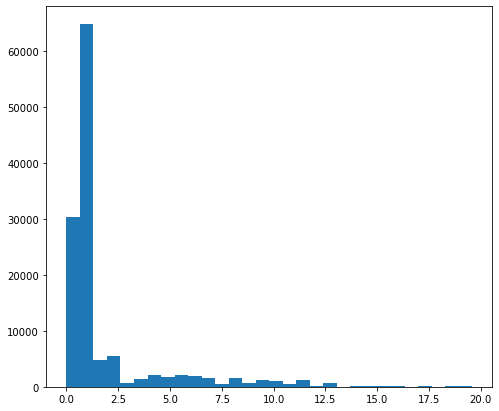

In [20]:
rcParams['figure.figsize'] = 8, 7
plt.hist(basa[basa['От станции'] <20]['От станции'],  bins=30) # посмотрим на распределение расстояний до станции метро
plt.show()

In [21]:
basa.drop(basa.loc[basa ['От станции']>4].index, inplace=True) # отбросим те экземпляры, где расстояние больше 4 км, так как их очень мало

In [22]:
def distance_parameter(arg): # Полученное расстояние превращаем в класс категории расстояния и преобразовываем в бинарный вектор
    
    out = arg
    outclass = 0
    if out > 0:
        outclass = 1
    if out > 0.5:
        outclass = 2
    if out > 1:
        outclass = 3
    if out > 2:
        outclass = 4
    if out > 3:
        outclass = 5
  
    return list(utils.to_categorical(outclass, 6).astype(int))

In [23]:
basa['Балкон'] = basa['Балкон'].replace(to_replace='\-', value = 0, regex=True)  # заменим "-" на 0(балкон отсутствует)
basa['Балкон'] = basa['Балкон'].replace(to_replace='\*', value = '', regex=True) 
print(basa['Балкон'].unique())

[nan 'Б' 'Л' '2Б' 0 '2Б2Л' 'БЛ' '3Б' '2Л' 'Эрк' 'Б2Л' 'ЭркЛ' '3Л' '4Л']


In [24]:
def balcony_parameter(arg): # преобразуем значения столбца "Балкон" в бинарный вектор
    out = 0
    if arg == arg: 
        if arg == 0: out = 1 # если балкона нет - первый класс
        if arg =="Л" or arg == "Б": out = 2 # если есть один балкон или лоджия - второй класс
        else:
            out = 3 # если больше 2х балконов или лоджий - третий класс
    else:
        out = 0 # если было значение nan - класс неопознанных значений
    return list(utils.to_categorical(out, 4).astype('int'))

In [25]:
basa['Санузел']=basa['Санузел'].replace(to_replace= "+", value = "Р")  # заменим + на раздельный санузел
basa['Санузел']=basa['Санузел'].replace(to_replace= "-", value = 0)    # заменим "-" на 0(санузел отсутствует)
print(basa['Санузел'].unique())

['2' 'С' 'Р' nan 0 '2С' '4Р' '2Р' '3С' '4С' '4' '3' '3Р']


In [26]:
def bathroom_parameter(arg): # преобразуем значения столбца "санузел" в бинарный вектор
    out = 0
    if arg == arg:
        if arg == 0: out = 1 # если санузла нет - первый класс
        else: out = 2        # если санузел есть - второй класс
    else:
        out = 0              # 0 класс - неопознанное значение
    return list(utils.to_categorical(out, 3).astype('int'))

In [27]:
basa.head()

,Комнат,Метро,От станции,Балкон,Санузел,Площадь,"Цена, руб."
0,1,Шелепиха,1.000,NaN,2,64.1/23/20,19500000.0
2,1,Планерная,2.083,Б,С,38.2/19.9/9.9,7990000.0
3,1,Шаболовская,1.000,Б,Р,38/15/7,11200000.0
4,1,Бабушкинская,1.250,NaN,С,34/17/8,6250000.0
5,1,Шелепиха,1.250,NaN,NaN,44/14.7/19.2,12700000.0


In [28]:
basa['Площадь'] = basa['Площадь'].replace(to_replace=r'/.+', value ='', regex=True) #Площадь всей квартиры - это первое число из трех
basa['Площадь'].unique()                                                            #в столбце "Площадь"

array(['64.1', '38.2', '38', ..., '199.2', '180.8', '15.12.2002'],
      dtype=object)

In [29]:
basa.drop(basa.loc[basa ['Площадь'].map(len)>6].index, inplace=True)  # уберем квартиры, где вместо площади были записаны даты
basa.drop(basa.loc[basa ['Площадь'].map(len)==1].index, inplace=True) # уберем квартиры, где вместо площади были записаны "?"

In [30]:
basa['Площадь']= basa['Площадь'].astype(float)

In [31]:
print(basa['Площадь'].unique())

[ 64.1  38.2  38.  ...  10.9 199.2 180.8]


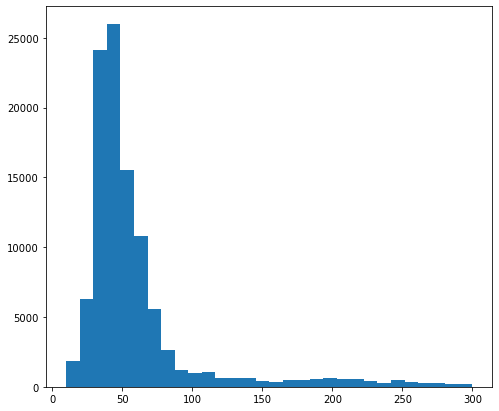

In [32]:
plt.hist(basa[basa['Площадь'] <300]['Площадь'],  bins=30)
plt.show()

In [33]:
basa.drop(basa.loc[basa ['Площадь']>100].index, inplace=True) #уберем квартиры с площадью больше 250 кв м, так как их очень мало

In [34]:
def square_parameter(arg):# преобразуем значения столбца "Площадь" в бинарный вектор
    out = arg
    outclass = 0
    if out > 20:
        outclass = 1
    if out > 30:
        outclass = 2
    if out > 40:
        outclass = 3
    if out > 50:
        outclass = 4
    if out > 70:
        outclass = 5
    if out > 100:
        outclass = 6
    return list(utils.to_categorical(outclass, 7).astype(int))  

In [35]:
def price(arg): 
    arg = arg*0.000001
    return arg

In [36]:
basa['Цена, руб.'] = basa['Цена, руб.'].astype(float).round(3)

In [37]:
basa['Цена, руб.'] = [price(cell) for cell in basa['Цена, руб.']]

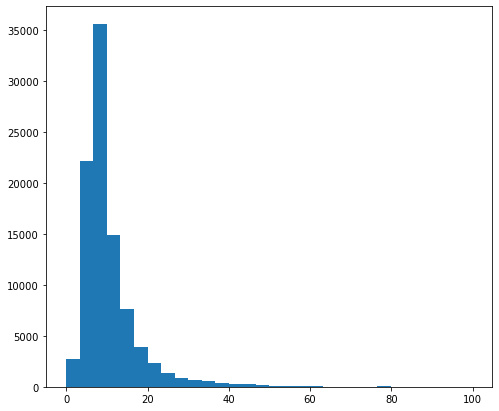

In [38]:
rcParams['figure.figsize'] = 8, 7
plt.hist(basa[basa['Цена, руб.'] <100]['Цена, руб.'],  bins=30)
plt.show()

In [39]:
basa.drop(basa.loc[basa ['Цена, руб.']>25].index, inplace=True) #уберем квартиры с ценой больше 30 млн, так как их очень мало

In [40]:
basa.head(20) # посмотрим на таблицу до преобразования

,Комнат,Метро,От станции,Балкон,Санузел,Площадь,"Цена, руб."
0,1,Шелепиха,1.000,NaN,2,64.1,19.500000
2,1,Планерная,2.083,Б,С,38.2,7.990000
3,1,Шаболовская,1.000,Б,Р,38.0,11.200000
4,1,Бабушкинская,1.250,NaN,С,34.0,6.250000
5,1,Шелепиха,1.250,NaN,NaN,44.0,12.700000
6,1,Улица Дмитриевского,0.167,Л,Р,43.0,6.500000
7,1,Бульвар Рокоссовского,0.167,Б,С,31.0,6.000000
8,1,Марьина Роща,0.833,2Б,NaN,38.9,8.900000
9,1,Марьино,1.667,NaN,0,30.9,5.999984
10,1,Марьино,2.083,Б,С,31.7,5.790000


In [41]:
funcList = [room_parameter, metro_parameter, distance_parameter, balcony_parameter, bathroom_parameter, square_parameter]
# все функции, которые должны преобразовать значения столбцов в бинарные векторы 

In [42]:
for i in range(len(basa.columns)-1):
    basa[basa.columns[i]] = [funcList[i](cell) for cell in basa[basa.columns[i]]]

In [43]:
basa = basa.rename(columns={'От станции': 'Расстояние', 'Цена, руб.' : 'Цена'}) # переименуем столбцы для удобства

In [44]:
basa.head(20) # посмотрим на таблицу после преобразования

,Комнат,Метро,Расстояние,Балкон,Санузел,Площадь,Цена
0,"[1, 0, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0]","[0, 0, 1, 0, 0, 0]","[1, 0, 0, 0]","[0, 0, 1]","[0, 0, 0, 0, 1, 0, 0]",19.500000
2,"[1, 0, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 1, 0]","[0, 0, 1, 0]","[0, 0, 1]","[0, 0, 1, 0, 0, 0, 0]",7.990000
3,"[1, 0, 0, 0, 0]","[0, 0, 0, 1, 0, 0, 0]","[0, 0, 1, 0, 0, 0]","[0, 0, 1, 0]","[0, 0, 1]","[0, 0, 1, 0, 0, 0, 0]",11.200000
4,"[1, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 1, 0]","[0, 0, 0, 1, 0, 0]","[1, 0, 0, 0]","[0, 0, 1]","[0, 0, 1, 0, 0, 0, 0]",6.250000
5,"[1, 0, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 1, 0, 0]","[1, 0, 0, 0]","[1, 0, 0]","[0, 0, 0, 1, 0, 0, 0]",12.700000
6,"[1, 0, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0]","[0, 1, 0, 0, 0, 0]","[0, 0, 1, 0]","[0, 0, 1]","[0, 0, 0, 1, 0, 0, 0]",6.500000
7,"[1, 0, 0, 0, 0]","[0, 0, 1, 0, 0, 0, 0]","[0, 1, 0, 0, 0, 0]","[0, 0, 1, 0]","[0, 0, 1]","[0, 0, 1, 0, 0, 0, 0]",6.000000
8,"[1, 0, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0]","[0, 0, 1, 0, 0, 0]","[0, 0, 0, 1]","[1, 0, 0]","[0, 0, 1, 0, 0, 0, 0]",8.900000
9,"[1, 0, 0, 0, 0]","[0, 0, 1, 0, 0, 0, 0]","[0, 0, 0, 1, 0, 0]","[1, 0, 0, 0]","[0, 1, 0]","[0, 0, 1, 0, 0, 0, 0]",5.999984
10,"[1, 0, 0, 0, 0]","[0, 0, 1, 0, 0, 0, 0]","[0, 0, 0, 0, 1, 0]","[0, 0, 1, 0]","[0, 0, 1]","[0, 0, 1, 0, 0, 0, 0]",5.790000


In [45]:
basa.shape

(90189, 7)

In [46]:
df_test = basa.copy()
x = df_test[['Комнат','Метро','Расстояние','Балкон','Санузел','Площадь']] # входные данные - первые 6 столбцов
x = x.sum(axis=1).to_frame()

In [47]:
x.head()

,0
0,"[1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
2,"[1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, ..."
4,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
5,"[1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [48]:
y = df_test[['Цена']]  # Последний столбец. Цена квартир, которую мы хотим получить на выходе нейросети

In [49]:
y.head()

,Цена
0,19.50
2,7.99
3,11.20
4,6.25
5,12.70


In [50]:
print(x.shape,y.shape)

(90189, 1) (90189, 1)


In [51]:
X = x.values
Y = y.values

In [52]:
print(X[0])

[list([1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0])]


In [53]:
def list_to_array(data):
    arr = []
    for i in range(len(data)):
        arr.append(data[i][0])
    return np.array(arr)

In [54]:
X = list_to_array(X)

In [55]:
Y = np.array(Y)

In [56]:
yScaler = StandardScaler()
yScaler.fit(Y.reshape(-1, 1))                     # Нормализуем цену по нормальному распределению
yTrainScaled = yScaler.transform(Y.reshape(-1, 1))

In [57]:
print(yTrainScaled)

[[ 2.32530135]
 [-0.31823149]
 [ 0.41901789]
 ...
 [-1.48726557]
 [-0.95901834]
 [-1.51252957]]


In [58]:
X_train, x_test, Y_train, y_test = train_test_split(X, yTrainScaled, test_size=0.1, shuffle=True) # выделяем тестовую выборку

In [59]:
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.2, shuffle=True) # разделяем оставшиеся данные на train и val

In [60]:
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

(64936, 32) (64936, 1)
(16234, 32) (16234, 1)
(9019, 32) (9019, 1)


In [91]:
def on_train_begin(logs):
    global losses
    global val_losses
    losses = []
    val_losses = []
    
def on_epoch_end(epoch,logs):
    print("Эпоха: ",epoch)
    
    losses.append(list(logs.values())[0])
    val_losses.append(list(logs.values())[1])
    
    if epoch > 5:
        temp_loss = val_losses[epoch-5:]
        if np.mean(temp_loss) < np.min(temp_loss)+0.01:
            model.optimizer.lr.assign(K.eval(model.optimizer.lr)*3)           #Меняем шаг обучения, если попали на "Плато"
            print('Шаг обучения был изменён по причине: "Плато"')
            print("Новый шаг обучения:",round(K.eval(model.optimizer.lr),5))
            
            
        if np.mean(temp_loss) > np.min(temp_loss)+0.1:
            model.optimizer.lr.assign(K.eval(model.optimizer.lr)*0.5)
            print('Шаг обучения был изменён по причине: "mse начала расти"') # Уменьшаем шаг обучения, если значение потерь начало расти 
            print("Новый шаг обучения:",round(K.eval(model.optimizer.lr),5))

In [92]:
clbk = LambdaCallback(on_train_begin=on_train_begin,on_epoch_end=on_epoch_end)

In [99]:
def createModel():  # функция, создающая полносвязную сеть
    
    model = Sequential()
    
    model.add(Dense(32,input_dim=32, activation='relu'))
    
    model.add(Dropout(0.2))
    

    model.add(Dense(16, activation='relu'))
    
    model.add(Dropout(0.2))

    model.add(Dense(1, activation='linear'))

    model.compile(optimizer=Adam(learning_rate=1e-4), loss='mse', metrics=['mae'])
    
    model.summary()

    return model 

In [100]:
model = createModel()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 32)                1056      
                                                                 
 dropout_10 (Dropout)        (None, 32)                0         
                                                                 
 dense_16 (Dense)            (None, 16)                528       
                                                                 
 dropout_11 (Dropout)        (None, 16)                0         
                                                                 
 dense_17 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,601
Trainable params: 1,601
Non-trainable params: 0
_________________________________________________________________


In [101]:
history = model.fit(x_train, y_train,   #обучаем модель
                    batch_size=256, 
                    epochs=20,
                    validation_data=(x_val,y_val), 
                    verbose=1,
                    callbacks = clbk) 

Epoch 1/20
254/254 [==============================] - 2s 6ms/step - loss: 0.9999 - mae: 0.7520 - val_loss: 0.8098 - val_mae: 0.6681
Epoch 2/20
254/254 [==============================] - 1s 5ms/step - loss: 0.8216 - mae: 0.6659 - val_loss: 0.6889 - val_mae: 0.6025
Epoch 3/20
254/254 [==============================] - 1s 5ms/step - loss: 0.7364 - mae: 0.6264 - val_loss: 0.6259 - val_mae: 0.5642
Epoch 4/20
254/254 [==============================] - 1s 5ms/step - loss: 0.6890 - mae: 0.6034 - val_loss: 0.5876 - val_mae: 0.5449
Epoch 5/20
254/254 [==============================] - 1s 5ms/step - loss: 0.6559 - mae: 0.5856 - val_loss: 0.5558 - val_mae: 0.5236
Epoch 6/20
254/254 [==============================] - 1s 5ms/step - loss: 0.6283 - mae: 0.5709 - val_loss: 0.5331 - val_mae: 0.5111
Epoch 7/20
254/254 [==============================] - 1s 5ms/step - loss: 0.6057 - mae: 0.5581 - val_loss: 0.5136 - val_mae: 0.4992
Epoch 8/20
254/254 [==============================] - 1s 5ms/step - loss: 0.

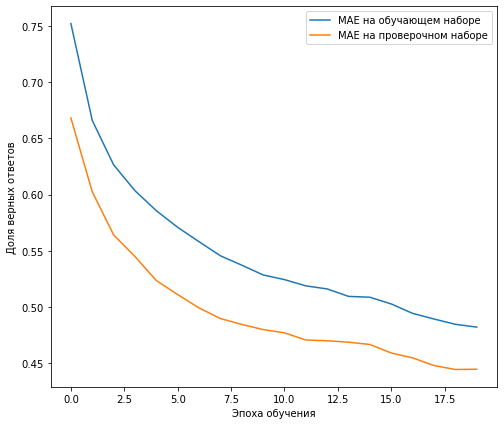

In [102]:
plt.plot(history.history['mae'],            #смотрим, как изменялась MAE на этапе обучения и проверки
         label='MAE на обучающем наборе')
plt.plot(history.history['val_mae'], 
         label='MAE на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [103]:
pred = model.predict(x_test)
predUnscaled = yScaler.inverse_transform(pred).flatten()
yTestUnscaled = yScaler.inverse_transform(y_test).flatten()  # Предсказываем цену квартир из тестовой выборки
delta = predUnscaled - yTestUnscaled
absDelta = abs(delta)
print(round(sum(absDelta) / (len(absDelta)),3))              # Ошибка получилась в среднем 2 миллиона рублей

1.942


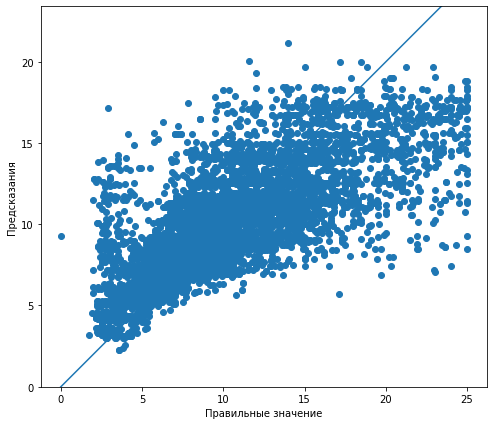

In [104]:
plt.scatter(yTestUnscaled, predUnscaled) 
plt.xlabel('Правильные значение')
plt.ylabel('Предсказания')
plt.axis('equal')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
plt.plot([-1000, 1000], [-1000, 1000])                       # Как можно заметить из графика, чаще всего нейросеть ошибалась
plt.show()                                                   # в ценах дорогих квартир(больше 15 миллионов)
                                                             # Данный результат не удивителен, ведь на цену таких квартир 
                                                             # влияет гораздо больше данных, чем те, что были у нас в наличии